# Ship Detection Project 2020
## Marwan Kalo - Flatiron School

## Notebook 1: Image Classification - Identifying satellite images that contain ships

### The first stage of this project will lay out a model that classifies satellite images into two classes - those that contain ships and those that do not.

## EDA

Importing relevant packages 

In [250]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
from PIL import Image, ImageDraw
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop

from sklearn.metrics import accuracy_score,roc_auc_score, f1_score, recall_score
from sklearn.metrics import  roc_curve, confusion_matrix, precision_score, classification_report

Importing images from JSON file

In [164]:
image_file = open(r'./raw_data/shipsnet.json')
dataset = json.load(image_file)
image_file.close()

In [165]:
# Closer look at what the dataset contains
dataset.keys()

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

Converting dataset into a numpy array and separating labels from images

In [166]:
data = np.array(dataset['data']).astype('uint8')
labels = np.array(dataset['labels']).astype('uint8')

In [167]:
print('Data shape', data.shape)
print('Labels shape', labels.shape)

Data shape (4000, 19200)
Labels shape (4000,)


We are given the dimensions and number of channels 80x80 and RGB therefore we can reshape our data to visualise some of the images

In [168]:
channels = 3
height = 80
width = 80

# Setting input data as X variable
X = data.reshape(-1, 3, width, height).transpose([0,2,3,1])
X.shape

# Confirming new shape
print('X shape', X.shape)

X shape (4000, 80, 80, 3)


### Understanding and Visualising the data

In [7]:
# Setting font dictionary for formatting visuals
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16}

In [8]:
# Function that sets appropriate title
def ship_or_not(im):
    if labels[im]==1:
        plt.title('Ship Present', fontdict=font, pad=10)
        plt.imshow(X[im])
    else:
        plt.title('No Ship Present', fontdict=font, pad=10)
        plt.imshow(X[im])

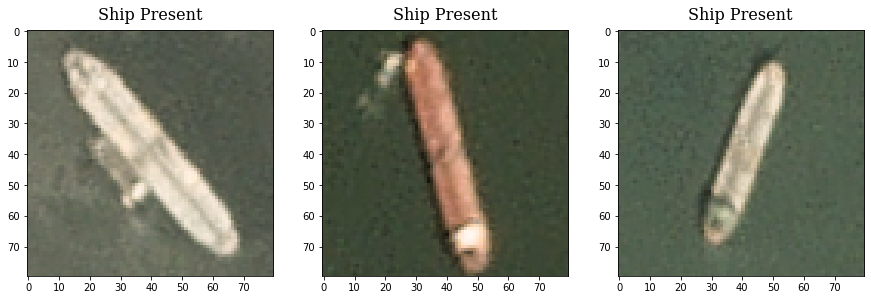

In [87]:
# Visualising ships present
fig = plt.figure(figsize=((5*3),(5*1)))

plt.subplot(1, 3, 1)
ship_or_not(50)
# plt.annotate(('Coordinates:', dataset['locations'][50],4), xy=(-0.2, -0.2), xycoords='axes fraction')


plt.subplot(1, 3, 2)
ship_or_not(60)
# plt.annotate(('Coordinates:', dataset['labels'][60]), xy=(0.2, -0.2), xycoords='axes fraction')


plt.subplot(1, 3, 3)
ship_or_not(70)
# plt.annotate(('Coordinates:', dataset['labels'][70]), xy=(0.2, -0.2), xycoords='axes fraction')


plt.show()

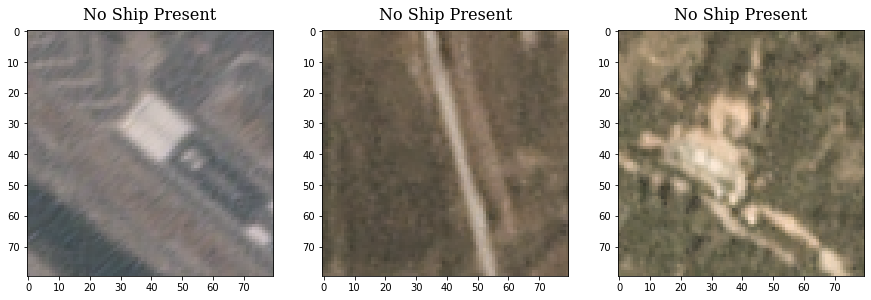

In [66]:
# Visualising no ships present

fig = plt.figure(figsize=((5*3),(5*1)))

plt.subplot(1, 3, 1)
ship_or_not(3000)

plt.subplot(1, 3, 2)
ship_or_not(3001)

plt.subplot(1, 3, 3)
ship_or_not(3002)
plt.show()

Checking the number of each class - are they balanced?

In [11]:
print('Number of images without a ship', np.bincount(labels)[0])
print('Number of images containing a ship', np.bincount(labels)[1])

Number of images without a ship 3000
Number of images containing a ship 1000


This indicates that there is a 3:1 class imbalance.

### Preparing our data for modelling

Our first stage of modelling will involve using a decision tree classifier, random forest and binary logistic regression prior to using a convolutional neural network that is usually the best performer on image classification tasks.

In [169]:
# Setting output data as y variable
y = labels
y.shape

(4000,)

In [170]:
# Normalisation of pixel intensities
X = X/255

In [14]:
# Train / Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [15]:
# Validation Split
X_train_v, X_val, y_train_v, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [16]:
X_train_v = X_train_v.reshape(2560, 19200)
X_val = X_val.reshape(640, 19200)
X_train = X_train.reshape(3200, 19200)
X_test = X_test.reshape(800, 19200)

### Building a baseline model: Decision Tree Classifier

In [17]:
# Instantiating a decision tree classifier 
from sklearn.tree import DecisionTreeClassifier
dtc_1 = DecisionTreeClassifier(max_depth=2,min_samples_leaf=10,random_state=42)

In [18]:
dtc_1.fit(X_train_v,y_train_v)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=10, random_state=42)

In [19]:
from sklearn.metrics import roc_curve,auc

# Plotting area under roc curve
probs = dtc_1.predict_proba(X_train_v)[:,1]
y_pred = dtc_1.predict(X_train_v)

fpr,tpr,thr = roc_curve(y_train_v,probs)

print('Training roc_auc:',auc(fpr,tpr))
print('Training accuracy:', accuracy_score(y_train_v, y_pred))

Training roc_auc: 0.8867193118372365
Training accuracy: 0.86796875


In [20]:
# Checking validation performance
from sklearn.metrics import accuracy_score

probs_val = dtc_1.predict_proba(X_val)[:,1]
y_val_pred = dtc_1.predict(X_val)

fpr,tpr,thr = roc_curve(y_val,probs_val)

print('Training roc_auc:',auc(fpr,tpr))
print('Validation accuracy:', accuracy_score(y_val, y_val_pred))

Training roc_auc: 0.87255736614566
Validation accuracy: 0.8625


Strong performance displayed by our baseline model with very little overfitting - time to tune some hyperparameters

### Decision Tree Classifier: Tuning I

I apply a 5-fold cross validation and tune the min_samples_leaf and max_depth parameters

In [21]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,random_state=42)

/Users/marwankalo/opt/anaconda3/envs/ship_detection_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [22]:
param_grid = {'max_depth':range(10,50+1,10),'min_samples_leaf':[5,10,15,20]}

In [24]:
from sklearn.model_selection import GridSearchCV

dtc_1_tuned = GridSearchCV(dtc_1,param_grid,cv=skf,scoring='accuracy',return_train_score=True,n_jobs=-1)

In [25]:
dtc_1_tuned.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             estimator=DecisionTreeClassifier(max_depth=2, min_samples_leaf=10,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(10, 51, 10),
                         'min_samples_leaf': [5, 10, 15, 20]},
             return_train_score=True, scoring='accuracy')

In [26]:
dtc_1_tuned.best_params_

{'max_depth': 20, 'min_samples_leaf': 5}

In [27]:
print('Accuracy on validation set:', round(dtc_1_tuned.best_score_,3))

Accuracy on validation set: 0.909


Great stuff - our model performance has increased to almost 91% on our test set however a 6% drop as compared to the training accuracy (97%) implying some overfitting.

### Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier
model_rf_1 = RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=42)
model_rf_1.fit(X_train_v,y_train_v)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [29]:
y_val_pred = model_rf_1.predict(X_val)
y_pred = model_rf_1.predict(X_train_v)

In [30]:
print('Training accuracy:', accuracy_score(y_train_v, y_pred))
print('Validation accuracy:', accuracy_score(y_val, y_val_pred))

Training accuracy: 1.0
Validation accuracy: 0.9375


Our best performance yet! The model displays considerable overfitting but this is expected with random forest classifiers

### Random Forest Classifier: Tuning I

In [31]:
skf = StratifiedKFold(n_splits=5,random_state=42)

/Users/marwankalo/opt/anaconda3/envs/ship_detection_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [32]:
param_grid = {'max_depth':[10,20,30],'min_samples_leaf':[5,10]}

In [33]:
model_rf_tuned = GridSearchCV(model_rf_1,param_grid,cv=skf,scoring='accuracy',return_train_score=True,n_jobs=-1)

In [34]:
# model_rf_tuned.fit(X_train, y_train)

I tried to fit the tuned random forest (above) however my system was incapable - we shall use the basline random forest accuracy as our benchmark for proceeding (0.938)

### Binary Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

model_lr_1 = LogisticRegression(penalty='none', solver='lbfgs')
model_lr_1.fit(X_train_v,y_train_v)

/Users/marwankalo/opt/anaconda3/envs/ship_detection_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:760: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(penalty='none')

In [36]:
y_pred = model_lr_1.predict(X_train_v)
y_val_pred = model_lr_1.predict(X_val)

print('Training accuracy:', round(accuracy_score(y_train_v, y_pred),4))
print('Validation accuracy:', round(accuracy_score(y_val, y_val_pred),4))

Training accuracy: 0.9961
Validation accuracy: 0.9062


The logistic regression is the performs well however overfits considerably! Let's move now onto convolutional neural networks.

### Convolutional Neural Network

A Convolutional Neural Network is a Deep Learning method which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. It is used as the industry standard for image classification tasks.

In [171]:
# Pre-processing for CNN 

print(X.shape)
print(y.shape)

y = to_categorical(labels, num_classes=2)
print('New output shape:',y.shape)

(4000, 80, 80, 3)
(4000,)
New output shape: (4000, 2)


In [172]:
# Split again using same random_state
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)

In [173]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=False)

In [174]:
# Shuffling data to ensure randomness
indexes = np.arange(2048)
np.random.shuffle(indexes)

In [176]:
X_train = X_train[indexes] #.reshape(-1, 3, width, height).transpose([0,2,3,1])
y_train = y_train[indexes]
X_train.shape

(2048, 80, 80, 3)

In [185]:
# This function builds a visualisation of how the model's loss and accuracy changes over each epoch
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss', pad=10)
    plt.xlabel('Epochs', labelpad=5)
    plt.ylabel('Loss', labelpad=5)
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy', pad=10)
    plt.xlabel('Epochs', labelpad=5)
    plt.ylabel('Accuracy', labelpad=5)
    plt.show()

In [148]:
# Setting optimizer parameters to use when compiling CNN
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
rms = RMSprop(learning_rate=0.000001)

In [43]:
# Instantiating sequential CNN model
cnn_1 = Sequential()

cnn_1.add(Conv2D(64, (3, 3), padding="same", input_shape=(80, 80, 3), activation='relu'))
cnn_1.add(MaxPooling2D(pool_size=(2, 2)))

cnn_1.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
cnn_1.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
cnn_1.add(Dropout(0.2))


cnn_1.add(Flatten())

cnn_1.add(Dense(128, activation='relu'))
cnn_1.add(Dense(2,activation='sigmoid'))

cnn_1.compile(optimizer=sgd,metrics=['accuracy'],loss='binary_crossentropy')

cnn_1.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 80, 80, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 32)        18464     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 40, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

In [44]:
# Fitting our model to our training data
history = cnn_1.fit(X_train, y_train, batch_size=32, 
                    epochs=10, validation_data=(X_val, y_val))

Train on 2048 samples, validate on 640 samples
Epoch 1/10
2048/2048 [==============================] - 14s 7ms/step - loss: 0.4143 - accuracy: 0.8257 - val_loss: 0.2508 - val_accuracy: 0.9016
Epoch 2/10
2048/2048 [==============================] - 14s 7ms/step - loss: 0.2388 - accuracy: 0.8950 - val_loss: 0.1816 - val_accuracy: 0.9328
Epoch 3/10
2048/2048 [==============================] - 14s 7ms/step - loss: 0.2038 - accuracy: 0.9180 - val_loss: 0.1438 - val_accuracy: 0.9406
Epoch 4/10
2048/2048 [==============================] - 14s 7ms/step - loss: 0.1995 - accuracy: 0.9177 - val_loss: 0.1674 - val_accuracy: 0.9391
Epoch 5/10
2048/2048 [==============================] - 14s 7ms/step - loss: 0.1559 - accuracy: 0.9363 - val_loss: 0.1186 - val_accuracy: 0.9508
Epoch 6/10
2048/2048 [==============================] - 14s 7ms/step - loss: 0.1389 - accuracy: 0.9475 - val_loss: 0.1221 - val_accuracy: 0.9500
Epoch 7/10
2048/2048 [==============================] - 14s 7ms/step - loss: 0.1085

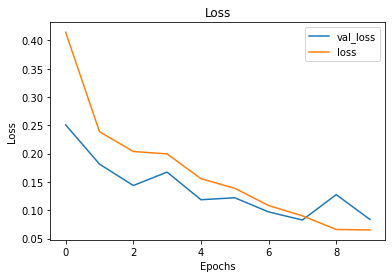

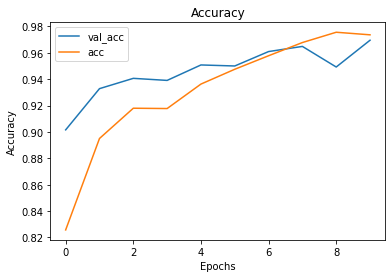

In [184]:
visualize_training_results(history)

In [183]:
print('Accuracy on validation:', cnn_1.evaluate(X_val,y_val))

640/640 [==============================] - 1s 2ms/step
Accuracy on validation: [0.0837547172792256, 0.969531238079071]


Our first model performs well off the bat using a combination of convolutional , pooling, dropout and dense layers. 

## Convolutional Neural Network: Iteration II

For the second iteration, I have added one more convolutional layer and after each individual convolutional layer a pooling and dropout layer to reduce the model's complexity as well as improve its ability to generalise. I have  increased the number of nodes in the penultimate fully-connected layer from 128 to 512. Finally I changed the activation function in the last layer to softmax as it seems to perform better with 'hot-encoded' outputs.

In [149]:
cnn_2 = Sequential()
cnn_2.add(Conv2D(64, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
cnn_2.add(MaxPooling2D(pool_size=(2, 2))) #40x40
cnn_2.add(Dropout(0.25))

cnn_2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_2.add(MaxPooling2D(pool_size=(2, 2))) #20x20
cnn_2.add(Dropout(0.25))

cnn_2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_2.add(MaxPooling2D(pool_size=(2, 2))) #10x10
cnn_2.add(Dropout(0.25))

cnn_2.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
cnn_2.add(MaxPooling2D(pool_size=(2, 2))) #5x5
cnn_2.add(Dropout(0.25))

cnn_2.add(Flatten())
cnn_2.add(Dense(512, activation='relu'))
cnn_2.add(Dropout(0.5))

cnn_2.add(Dense(2, activation='softmax'))

cnn_2.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

cnn_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 80, 80, 64)        1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 40, 40, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 20, 64)       

In [150]:
history_1 = cnn_2.fit(X_train, y_train, batch_size=32, 
                    epochs=20, validation_data=(X_val, y_val))

Train on 2048 samples, validate on 640 samples
Epoch 1/20
2048/2048 [==============================] - 15s 7ms/step - loss: 0.4637 - accuracy: 0.7969 - val_loss: 0.3294 - val_accuracy: 0.8734
Epoch 2/20
2048/2048 [==============================] - 15s 7ms/step - loss: 0.2849 - accuracy: 0.8804 - val_loss: 0.1798 - val_accuracy: 0.9375
Epoch 3/20
2048/2048 [==============================] - 15s 7ms/step - loss: 0.2146 - accuracy: 0.9067 - val_loss: 0.1549 - val_accuracy: 0.9547
Epoch 4/20
2048/2048 [==============================] - 15s 7ms/step - loss: 0.1900 - accuracy: 0.9233 - val_loss: 0.1566 - val_accuracy: 0.9531
Epoch 5/20
2048/2048 [==============================] - 15s 7ms/step - loss: 0.1695 - accuracy: 0.9268 - val_loss: 0.1364 - val_accuracy: 0.9594
Epoch 6/20
2048/2048 [==============================] - 15s 7ms/step - loss: 0.1727 - accuracy: 0.9297 - val_loss: 0.1619 - val_accuracy: 0.9500
Epoch 7/20
2048/2048 [==============================] - 15s 7ms/step - loss: 0.1275

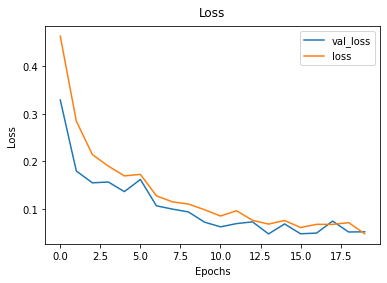

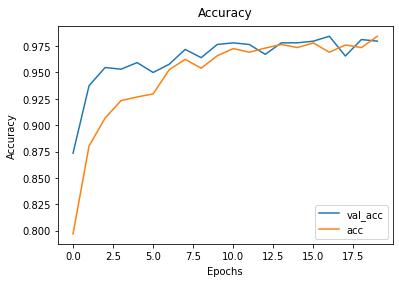

In [186]:
visualize_training_results(history_1)

In [206]:
print('Accuracy on validation:', cnn_2.evaluate(X_val,y_val))

640/640 [==============================] - 1s 2ms/step
Accuracy on validation: [0.051736902981065216, 0.979687511920929]


Looks like this is our best performing model - a 98% validation set accuracy!

## Evaluating best performing model on test set

In [182]:
print('Accuracy on test:', cnn_2.evaluate(X_test,y_test)[1])

800/800 [==============================] - 2s 2ms/step
Accuracy on test: 0.9787499904632568


Our new model perfoms almost perfectly on the test set (97.9% accuracy). Let's take a look at the area under the roc curve and examine how our model performs in terms of Type I and II errors. Let's take a look at some metrics.

In [153]:
# Converting labels back to binary format for roc computation
import pandas as pd
y_train = pd.DataFrame(y_train).idxmax(axis=1)
y_val = pd.DataFrame(y_val).idxmax(axis=1)
y_test = pd.DataFrame(y_test).idxmax(axis=1)

In [154]:
# Calculating false positive rate and true positive rate using predicted probabilities
train_probs = cnn_2.predict_proba(X_train)[:,1]
val_probs = cnn_2.predict_proba(X_val)[:,1]
test_probs = cnn_2.predict_proba(X_test)[:,1]

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, train_probs)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, val_probs)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_probs)

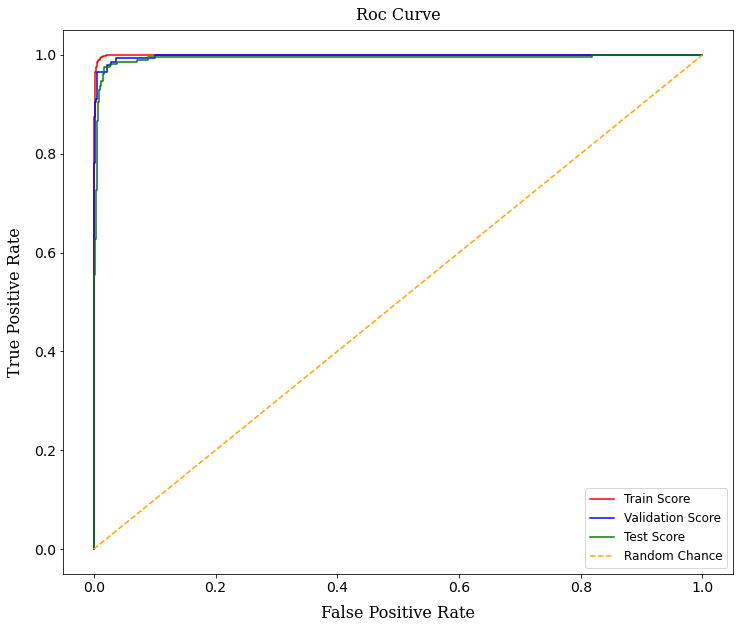

In [155]:
plt.figure(figsize=(12,10))

plt.plot(train_fpr,train_tpr, color='red')
plt.plot(val_fpr,val_tpr, color='blue')
plt.plot(test_fpr,test_tpr, color='green')
plt.plot([0,1],ls='--', color='orange')

plt.xlabel('False Positive Rate',labelpad=10, fontdict=font)
plt.ylabel('True Positive Rate', labelpad=10, fontdict=font)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(['Train Score','Validation Score', 'Test Score', 'Random Chance'], fontsize='large')


plt.title('Roc Curve', pad=10, fontdict=font)

plt.show()


In [195]:
y_test_preds = cnn_2.predict_classes(X_test)

In [199]:
confusion = confusion_matrix(y_test[:,1],y_test_preds)
confusion

array([[579,  12],
       [  5, 204]])

True Negatives = 579, False Negatives = 5, True Positives = 204, False Positives = 12

In [201]:
accuracy = print('Accuracy Score', accuracy_score(y_test[:,1], y_test_preds))
roc_score = print('ROC_score ', roc_auc_score(y_test[:,1], test_probs))
precision = print('Precision ', precision_score(y_test[:,1], y_test_preds))
recall= print('Recall or TPR ', recall_score(y_test[:,1], y_test_preds))
f1__score = print('F1 score ', f1_score(y_test[:,1], y_test_preds))
sensitivity =print('Sensitivity', (confusion[0,0])/(confusion[0,0]+confusion[0,1]))

Accuracy Score 0.97875
ROC_score  0.9926974797399591
Precision  0.9444444444444444
Recall or TPR  0.9760765550239234
F1 score  0.96
Sensitivity 0.9796954314720813


In [251]:
# Function to plot confusion matrix 
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
    cmap='Purples'):
 
   if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     print('Normalized confusion matrix')
   else:
     print('Confusion matrix, without normalization')
 
# print(cm)
   plt.figure(figsize=(8,8))  
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title, pad=10)
   plt.colorbar(shrink=0.75)
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes)
   plt.yticks(tick_marks, classes)
 
   fmt = '.2f' if normalize else 'd'
   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
   plt.tight_layout()
   plt.ylabel('True label', labelpad=5)
   plt.xlabel('Predicted label', labelpad=5)
   plt.show()

Confusion matrix, without normalization


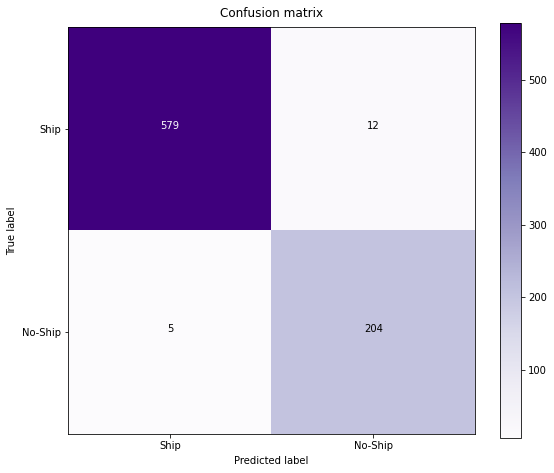

In [253]:
plot_confusion_matrix(confusion, ['Ship', 'No-Ship'])

The confusion matrix above visualises the classifcation errors in the model 